# FX Leverage Carry-Trade

Groupame: Blue Horseshoes

The project seeks to implement the well-known carry trade in Forex markets, which involves borrowing money in a low-yielding currency and investing it for a given period of time in a high-yielding currency. In our case, we consider ourselves as investors possessing JPY, and investing this in currencies including the GBP, AUD and USD. Since currency markets can be volatile, signals usually don't last for more than 2 or 3 months at a stretch - hence, we focus our efforts on rebalancing at tenors (time periods) of 1 week, 1 month and 2 months.

The two sets of decisions as investors that we have to make would be the choice of currency, as well as the duration of the investment. We tackle both decision by the use of the interest rate parity signal, which is $\frac{F(1 + r_f)}{S} - (1 + r_d)$ where F is the forward rate, S the spot rate and $r_f$ and $r_d$ the foreign and domestic currencies respectively (note the values of spot and forward rates are computed as CCYJPY, with CCY being the foreign currency). 

As $r_f$ varies across foreign currency and time periods, and $r_d$ solely across time periods, we determine the currency and time period that generates the highest possible signal to invest in. Once this is decided, we 1) convert the JPY into the currency 2) invest in the existing LIBOR/risk-free rate of the currency 3) convert the currency back into JPY at the prevailing rates at the end of the cycle 4) Repeat the process by determining the best signals.

In case none of the signals are positive, we choose to invest our equity overnight in an money-market fund offering a 0 % interest rate. The reason for this is that interest rates have been historically low in Japan (< 1%), with rates becoming negative since 2016. Our only alternative is to invest at the JPY LIBOR, which offers potentially negative interest rates. Most money managers and banks offer overnight rates at a slightly higher rate than the JPY LIBOR, which we assume to be 0 %. Furthermore, since we only consider a minimum tenor of 1 week, keeping our equity locked up over this period could potentially lead to us missing a 'good' signal. 

Another important feature of our strategy is the use of leverage. Most carry trades involve leverage, since the FX markets can often have long spells (regimes) of sideways movement with minimal returns. Leverage serves to amplify these returns, but can also contribute to magnified losses which could potentially wipe out the entire equity leading to bankruptcy. 

In [17]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import carry_trade as ct
import datetime as dt

from date_function_v2 import holiday_adjust

matplotlib.rcParams['figure.figsize'] = (16, 9)
font = {'family': 'normal',
        'size': 20}

matplotlib.rc('font', **font)

## 1. Load data

In [2]:
data_path_new = 'Data/to_send.csv'
final_data_new = pd.read_csv(data_path_new)

In [3]:
final_data_new = final_data_new.set_index('Date')
final_data_new.index = pd.to_datetime(final_data_new.index)

In [4]:
#final_data_new.iloc[324:]

## 2. Implement Strategy 

We implement the strategy for two broad scenarios, pre- and post-crisis. The pre-crisis scenario involves trading from September 2007 onwards, while the post-crisis scenario avoids some of the major volatility spikes and fluctuations observed in 2008 and invests from 2009 onwards. The scenarios assume a fairly conservative leverage ratio of 2.

In [5]:
# if you want to test single currency or single trading period, just modify the following list
fx_list = ['USD', 'AUD', 'GBP']
period_list = [7, 30, 60]

In [6]:
# idx, row_row = next(final_data.iterrows())
# ct.find_max_signal(row_row, period_list, fx_list)

In [7]:
results_pre_crisis = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 2.0) # pre-crisis scenario 
results_post_crisis = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 2.0)

2019-12-06 16:59:33:544220: Beginning Carry-Trade Strategy run
2019-12-06 16:59:49:169508: Algo run complete.
2019-12-06 16:59:49:170233: Beginning Carry-Trade Strategy run
2019-12-06 17:00:03:630418: Algo run complete.


In [8]:
results_pre_crisis.to_csv('Results/results_pre_crisis.csv')
results_post_crisis.to_csv('Results/results_post_crisis.csv')

In [9]:
results_post_crisis

,Signal,FX_name,Period,Foreign_IR,Domestic_IR,FX_Rate,Equity,Asset Pos,Unreal_Return,Real_Return,Drawdown
Date,,,,,,,,,,,
2009-01-02,0.000484649,GBP,2M,0.02505,0.0075625,133.563,10000,20000,0.0014587,0,0
2009-01-05,0.000484649,GBP,2M,0.02445,0.0073875,137.348,10000,20000,0.0591682,0,0
2009-01-06,0.000484649,GBP,2M,0.0240875,0.0071875,139.69,10000,20000,0.0946591,0,0
2009-01-07,0.000484649,GBP,2M,0.023675,0.007075,139.85,10000,20000,0.096636,0,0
2009-01-08,0.000484649,GBP,2M,0.0230375,0.0069375,138.773,10000,20000,0.0805256,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-05,5.13588e-05,AUD,2M,0.0092,-0.000965,75.247,16811.8,33623.7,0.0857553,0.681185,-0.301316
2019-11-06,5.13588e-05,AUD,2M,0.0093,-0.000935,75.024,16811.8,33623.7,0.0795475,0.681185,-0.301316
2019-11-07,5.13588e-05,AUD,2M,0.009183,-0.0010383,75.385,16811.8,33623.7,0.0895318,0.681185,-0.301316


In [10]:
print('Cumulative Return in the post-crisis scenario:', results_post_crisis['Real_Return'][-1])
print('Cumulative Return in the pre-crisis scenario:', results_pre_crisis['Real_Return'][-1])
print('Max Drawdown in the post-crisis scenario:', results_post_crisis['Drawdown'].min())
print('Max Drawdown in the pre-crisis scenario:', results_pre_crisis['Drawdown'].min())

Cumulative Return in the post-crisis scenario: 0.6811848552276105
Cumulative Return in the pre-crisis scenario: -0.3585947561379189
Max Drawdown in the post-crisis scenario: -0.3831904787844942
Max Drawdown in the pre-crisis scenario: -0.7247113114426323


In [11]:
# if you want to test single currency or single trading period, just modify the following list
usd_list = ['USD']
aud_list = ['AUD']
gbp_list = ['GBP']

In [12]:
results_usd = ct.algo_loop(final_data_new.iloc[324:], usd_list, period_list, leverage = 2.0)
results_aud = ct.algo_loop(final_data_new.iloc[324:], aud_list, period_list, leverage = 2.0)
results_gbp = ct.algo_loop(final_data_new.iloc[324:], gbp_list, period_list, leverage = 2.0)

2019-12-06 17:01:34:207545: Beginning Carry-Trade Strategy run
2019-12-06 17:01:45:075745: Algo run complete.
2019-12-06 17:01:45:076256: Beginning Carry-Trade Strategy run
2019-12-06 17:01:51:466926: Algo run complete.
2019-12-06 17:01:51:467367: Beginning Carry-Trade Strategy run
2019-12-06 17:01:59:488355: Algo run complete.


In [13]:
results_usd.to_csv('Results/results_usd.csv')
print('Cumulative Return, USD only:', results_usd['Real_Return'][-1])

Cumulative Return, USD only: 0.015332769349171382


In [14]:
results_aud.to_csv('Results/results_aud.csv')
print('Cumulative Return, AUD only:', results_aud['Real_Return'][-1])

Cumulative Return, AUD only: 0.3883647339032503


In [15]:
results_gbp.to_csv('Results/results_gbp.csv')
print('Cumulative Return, GBP only:', results_gbp['Real_Return'][-1])

Cumulative Return, GBP only: 0.32343472268958107


## 3. Analysis 

## 3.1 After Crisis

### 3.1.1 Realized Return Time Series

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


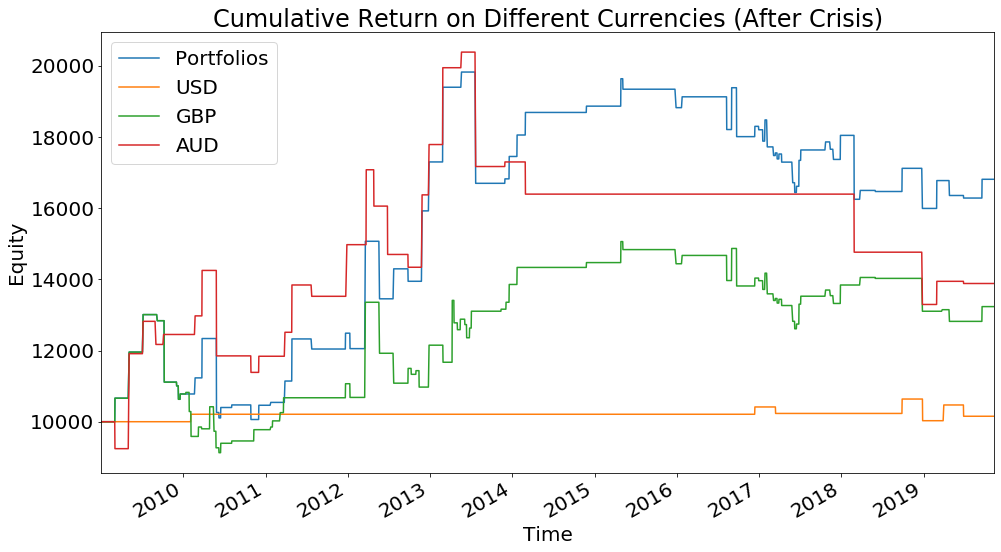

In [18]:
results_post_crisis['Equity'].plot(label='Portfolios')
results_usd['Equity'].plot(label='USD')
results_gbp['Equity'].plot(label='GBP')
results_aud['Equity'].plot(label='AUD')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Cumulative Return on Different Currencies (After Crisis)')
plt.show()
# plt.savefig('Results/Real_Return_4comb_post_crisis.jpg')

As you can see, the diversified portfolio tends to outperform but closely track the AUD portfolio, which makes sense due to the high spread between the Japanese and AUstralian interest rates

### 3.1.2 Realized Return Histogram

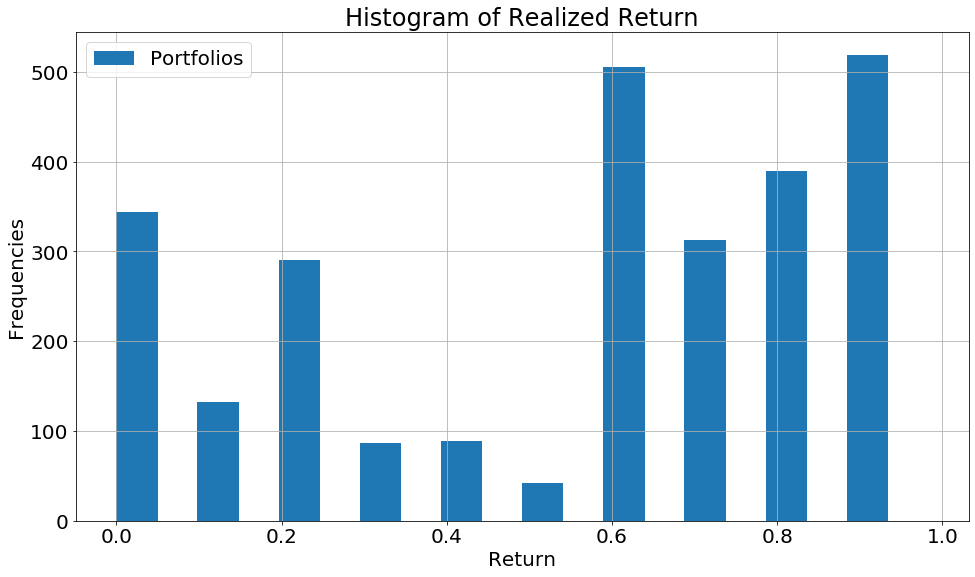

In [21]:
results_post_crisis['Real_Return'].hist(width=0.05, label='Portfolios')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Frequencies')
plt.title('Histogram of Realized Return')
plt.show()
# plt.savefig('Results/Real_Return_hist_post_crisis.jpg')

### 3.1.3 Unrealized Return Histogram

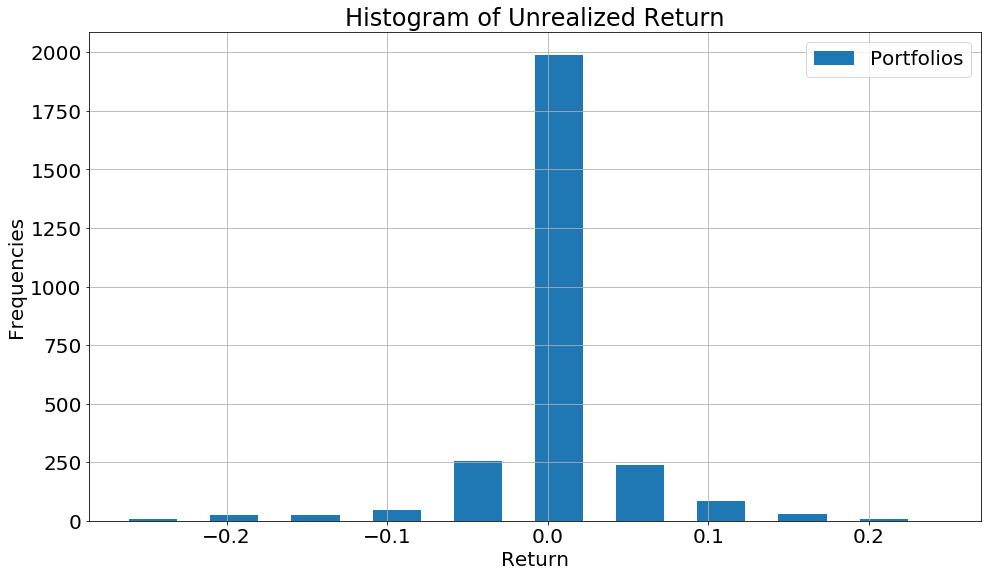

In [22]:
results_post_crisis['Unreal_Return'].hist(width=0.03, label='Portfolios')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Frequencies')
plt.title('Histogram of Unrealized Return')
plt.show()
# plt.savefig('Results/Unreal_Return_post_crisis.jpg')

### 3.1.4 Value at Risk

* sort return from smallest to largest
* calculate quantile(0.05) = 95%

In [24]:
return_post_crisis = results_post_crisis['Unreal_Return'].sort_values()
print('VaR at 90%:', return_post_crisis.quantile(0.1))
print('VaR at 95%:', return_post_crisis.quantile(0.05))
print('VaR at 99%:', return_post_crisis.quantile(0.01))

VaR at 90%: -0.017924809982412096
VaR at 95%: -0.04625538554631749
VaR at 99%: -0.1626349052729469


### 3.1.5 Sharpe Ratio and Volatility

# $\frac{\mu} {\sigma}$

In [25]:
sharpe_post_crisis =  results_post_crisis['Unreal_Return'].mean()/results_post_crisis['Unreal_Return'].std()
print('Sharpe Ratio each day:', sharpe_post_crisis)
print('Sharpe Ratio each year:', sharpe_post_crisis * np.sqrt(251))

Sharpe Ratio each day: 0.15823949102082854
Sharpe Ratio each year: 2.5069850151429405


In [26]:
volatility_post_crisis = results_post_crisis['Real_Return'].std()
print('Volatility, after crisis:', volatility_post_crisis)

Volatility, after crisis: 0.31550667123808457


## 3.2 Before Crisis vs. After Crisis

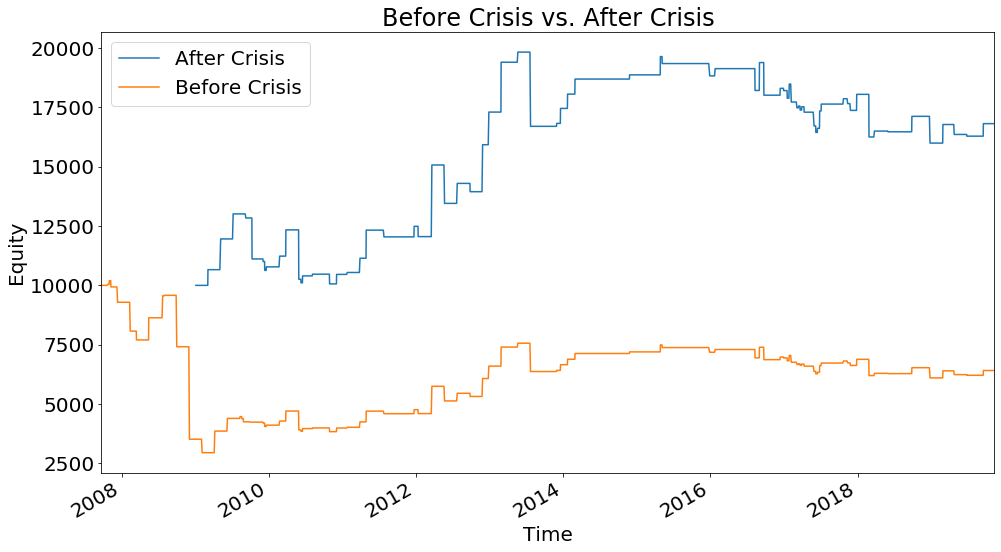

In [27]:
results_post_crisis['Equity'].plot(label='After Crisis')
results_pre_crisis['Equity'].plot(label='Before Crisis')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Before Crisis vs. After Crisis')
plt.savefig('Results/Real_Return_before&post_crisis.jpg')

### 3.2.1 Value at Risk

In [32]:
return_post_crisis = results_post_crisis['Unreal_Return'].sort_values()
print('VaR at 90%, after crisis:', return_post_crisis.quantile(0.1)* -1)
print('VaR at 95%, after crisis:', return_post_crisis.quantile(0.05)* -1)
print('VaR at 99%, after crisis:', return_post_crisis.quantile(0.01)* -1)

VaR at 90%, after crisis: 0.017924809982412096
VaR at 95%, after crisis: 0.04625538554631749
VaR at 99%, after crisis: 0.1626349052729469


In [31]:
return_pre_crisis = results_pre_crisis['Unreal_Return'].sort_values()
print('VaR at 90%, before crisis:', return_pre_crisis.quantile(0.1)* -1)
print('VaR at 95%, before crisis:', return_pre_crisis.quantile(0.05)* -1)
print('VaR at 99%, before crisis:', return_pre_crisis.quantile(0.01)* -1)

VaR at 90%, before crisis: 0.03720340479002022
VaR at 95%, before crisis: 0.09568580250763162
VaR at 99%, before crisis: 0.23524271427766016


### 3.2.2 Sharpe Ratio and Volatility

In [34]:
sharpe_pre_crisis =  results_pre_crisis['Unreal_Return'].mean()/results_pre_crisis['Unreal_Return'].std()
print('Daily Sharpe Ratio before crisis:', sharpe_pre_crisis)
print('Annual Sharpe Ratio before crisis:', sharpe_pre_crisis * np.sqrt(251))

Daily Sharpe Ratio before crisis: 0.011846622873341955
Annual Sharpe Ratio before crisis: 0.18768580353692282


In [35]:
volatility_pre_crisis = results_pre_crisis['Real_Return'].std()
print('Volatility, after crisis:', volatility_post_crisis)
print('Volatility, before crisis:', volatility_pre_crisis)

Volatility, after crisis: 0.31550667123808457
Volatility, before crisis: 0.1516022133265221


## 3.3 Leverage Analysis

### 3.3.1 After Crisis

In [36]:
results_post_crisis_l3 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 3.0)
results_post_crisis_l4 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 4.0)
results_post_crisis_l5 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 5.0)
results_post_crisis_l6 = ct.algo_loop(final_data_new.iloc[324:], fx_list, period_list, leverage = 6.0)

2019-12-06 17:16:47:149914: Beginning Carry-Trade Strategy run
2019-12-06 17:17:01:007987: Algo run complete.
2019-12-06 17:17:01:008455: Beginning Carry-Trade Strategy run
2019-12-06 17:17:14:952222: Algo run complete.
2019-12-06 17:17:14:952691: Beginning Carry-Trade Strategy run
2019-12-06 17:17:28:748623: Algo run complete.
2019-12-06 17:17:28:749143: Beginning Carry-Trade Strategy run
2019-12-06 17:17:42:865929: Algo run complete.


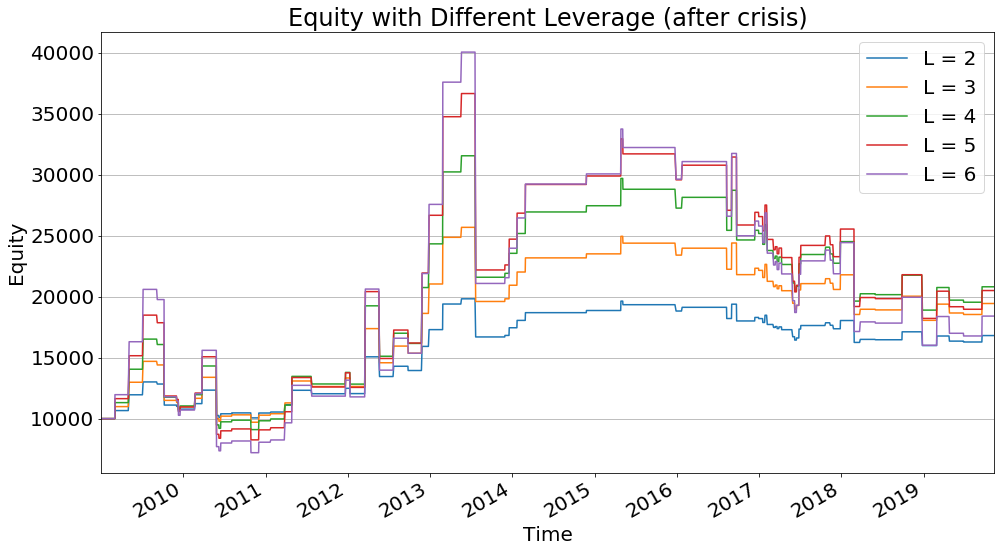

In [37]:
results_post_crisis['Equity'].plot(label='L = 2')
results_post_crisis_l3['Equity'].plot(label='L = 3')
results_post_crisis_l4['Equity'].plot(label='L = 4')
results_post_crisis_l5['Equity'].plot(label='L = 5')
results_post_crisis_l6['Equity'].plot(label='L = 6')
plt.grid(True, axis='y')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity with Different Leverage (after crisis)')
plt.savefig('Results/Real_Return_leverages_post_crisis.jpg')

In [38]:
sharpe_post_crisis =  results_post_crisis['Unreal_Return'].mean()/results_post_crisis['Unreal_Return'].std()
sharpe_post_crisis_l3 =  results_post_crisis_l3['Unreal_Return'].mean()/results_post_crisis_l3['Unreal_Return'].std()
sharpe_post_crisis_l4 =  results_post_crisis_l4['Unreal_Return'].mean()/results_post_crisis_l4['Unreal_Return'].std()
sharpe_post_crisis_l5 =  results_post_crisis_l5['Unreal_Return'].mean()/results_post_crisis_l5['Unreal_Return'].std()
sharpe_post_crisis_l6 =  results_post_crisis_l6['Unreal_Return'].mean()/results_post_crisis_l6['Unreal_Return'].std()


print('L2, Sharpe Ratio each year:', sharpe_post_crisis * np.sqrt(251))
print('L3, Sharpe Ratio each year:', sharpe_post_crisis_l3 * np.sqrt(251))
print('L4, Sharpe Ratio each year:', sharpe_post_crisis_l4 * np.sqrt(251))
print('L5, Sharpe Ratio each year:', sharpe_post_crisis_l5 * np.sqrt(251))
print('L6, Sharpe Ratio each year:', sharpe_post_crisis_l6 * np.sqrt(251))


L2, Sharpe Ratio each year: 2.5069850151429405
L3, Sharpe Ratio each year: 2.4963635317613964
L4, Sharpe Ratio each year: 2.4910487631126403
L5, Sharpe Ratio each year: 2.4878586178373836
L6, Sharpe Ratio each year: 2.485731320338369


### 3.3.2 Before Crisis

In [39]:
results_pre_crisis_l3 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 3.0)
results_pre_crisis_l4 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 4.0)
results_pre_crisis_l5 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 5.0)
results_pre_crisis_l6 = ct.algo_loop(final_data_new, fx_list, period_list, leverage = 6.0)

2019-12-06 17:19:55:027753: Beginning Carry-Trade Strategy run
2019-12-06 17:20:10:439449: Algo run complete.
2019-12-06 17:20:10:439679: Beginning Carry-Trade Strategy run
2019-12-06 17:20:10:978828: Algo run complete.
2019-12-06 17:20:10:979062: Beginning Carry-Trade Strategy run
2019-12-06 17:20:11:507485: Algo run complete.
2019-12-06 17:20:11:507704: Beginning Carry-Trade Strategy run
2019-12-06 17:20:12:061904: Algo run complete.


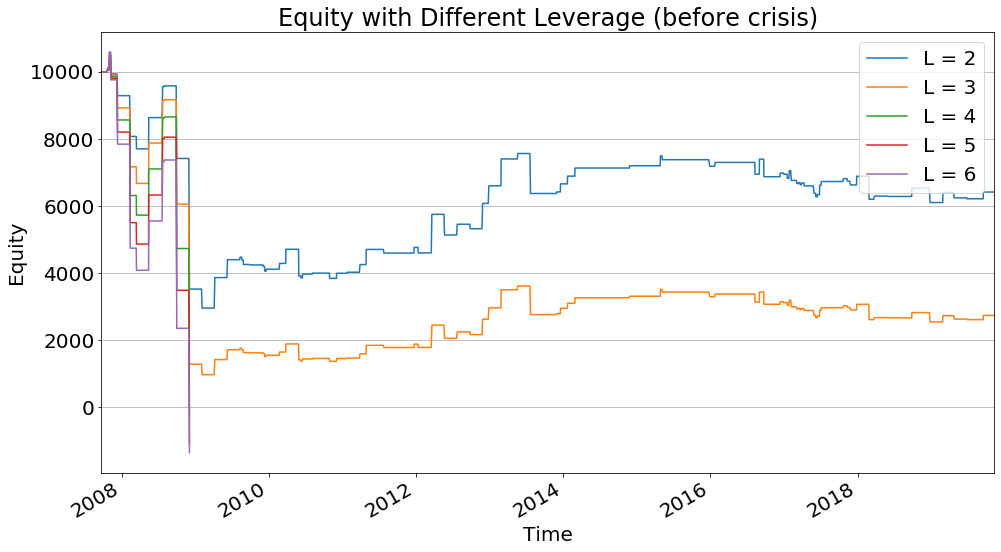

In [40]:
results_pre_crisis['Equity'].plot(label='L = 2')
results_pre_crisis_l3['Equity'].plot(label='L = 3')
results_pre_crisis_l4['Equity'].plot(label='L = 4')
results_pre_crisis_l5['Equity'].plot(label='L = 5')
results_pre_crisis_l6['Equity'].plot(label='L = 6')
plt.grid(True, axis='y')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity with Different Leverage (before crisis)')
plt.savefig('Results/Real_Return_leverage_before_crisis.jpg')

In [41]:
sharpe_pre_crisis =  results_pre_crisis['Unreal_Return'].mean()/results_pre_crisis['Unreal_Return'].std()
sharpe_pre_crisis_l3 =  results_pre_crisis_l3['Unreal_Return'].mean()/results_pre_crisis_l3['Unreal_Return'].std()
sharpe_pre_crisis_l4 =  results_pre_crisis_l4['Unreal_Return'].mean()/results_pre_crisis_l4['Unreal_Return'].std()
sharpe_pre_crisis_l5 =  results_pre_crisis_l5['Unreal_Return'].mean()/results_pre_crisis_l5['Unreal_Return'].std()
sharpe_pre_crisis_l6 =  results_pre_crisis_l6['Unreal_Return'].mean()/results_pre_crisis_l6['Unreal_Return'].std()


print('L2, Sharpe Ratio each year:', sharpe_pre_crisis * np.sqrt(251))
print('L3, Sharpe Ratio each year:', sharpe_pre_crisis_l3 * np.sqrt(251))
print('L4, Sharpe Ratio each year:', sharpe_pre_crisis_l4 * np.sqrt(251))
print('L5, Sharpe Ratio each year:', sharpe_pre_crisis_l5 * np.sqrt(251))
print('L6, Sharpe Ratio each year:', sharpe_pre_crisis_l6 * np.sqrt(251))

L2, Sharpe Ratio each year: 0.18768580353692282
L3, Sharpe Ratio each year: 0.17116406192954942
L4, Sharpe Ratio each year: -5.840165927156961
L5, Sharpe Ratio each year: -5.852224515308024
L6, Sharpe Ratio each year: -5.860262097416548
